# Evaluating Housing Classification models on CASAFARI data

This notebook aims to provide a comparison between housing classification models.

Considerations:
* This report covers a range of stages that are usually done when offering a solution for a business problem.

* It is based on how my team and I deliver reports to our stakeholders (Our reports includes also Error Analysis, Threshold definition, etc).

* It is not the point to perform all possible feature transformations.

* As I only had 4 hours, I chose the most important steps of model benchmarking.



* Author: Jessica Silva
* Date: 12-07-2022

In [1]:
from pathlib import Path

In [2]:
# project directory
project_dir = Path(".").resolve().parent

## 1. Data

In this section, we are going to perform the Exploratory Data Analysis and the generation of training, validation, and test sets.

In [3]:
import pandas as pd
from src.data.read_dataset import get_data
pd.set_option('display.max_colwidth', None)

### 1.1 CASAFARI Housing Dataset

The CASAFARI dataset contains ∼13, 400 entries and was generated and labelled by trained annotators over four rounds of dynamic data creation. Apartment entries make up ∼60% of the dataset.

The dataset is a json file (e.g. assessment_NLP.json) and the columns are: **bathrooms**, **bedrooms**, **description**, **features**, **living_area**, **location**, **location_id**, **plot_area**, **price**, **rent_price**, **rent_status**, **status**, **subtype**, **terrace_area**, **title**, **total_area**, **uid**, and **label**. The file must be inside the **./data/raw/** directory and the extension must be .json:
* **label**: is a binary variable, indicating whether or not the content has been identified as Apartment or House. It takes two values: Apartment (0), House (1).

In [4]:
DATASET_FILE = project_dir / "data" / "processed" / "df_dataset.csv"

In [5]:
df = pd.read_csv(DATASET_FILE, delimiter=",",
                             header=0, encoding='utf-8', engine='python')

In [6]:
df.head(3)

,bathrooms,bedrooms,description,features,living_area,location,location_id,plot_area,price,rent_price,rent_status,status,subtype,terrace_area,title,total_area,uid,label
0,2,2,Proyecto Hogar propone en venta espectacular piso de 88 m2 totalmente reformado a estrenar en una de las mejores zonas del barri,2 habitaciones; Superficie 88 m2; 2 baños,0.0,Barcelona,10565,0.0,290000,0,none,hold,NaN,0.0,Casa espectacular piso en tenor masini en Sants Barcelona,88.0,108974482,Apartment
1,0,0,"¡Viviendas en La Rambla!Bien situadas, en un entorno tranquilo y bien comunicado con el centro. Pisos con 3 habitaciones, 1 baño y 1 aseo. Con buenos acabados, carpintería exterior de aluminio y doble acristalamiento, carpintería interior de madera y suelos de mármol (excepto en cocina y baños que son de gres). Las viviendas cuentan con plaza de parking incluida (consulta disponibilidad y precios) y hay posibilidad de adquirir más plazas de parking en el mismo edificio.Solicita más información sin ningún tipo de compromiso.","Ficha Inmueble Ficha Inmueble; Habitantes: 7.576; Número de hogares: 3.866; Edad media de las personas: 40 años; % extranjeros: 0%; Nivel medio de estudios: Secundaria; % dedicadas a segunda residencia: 7%; Nº de hoteles por cada 1.000 habitantes residentes: 0,3; Número de farmacias: 5; Número de escuelas de primaria: 8; Número de escuelas de secundaria: 3; Número de estaciones de ferrocarril: 1",0.0,"rambla, la, córdoba",307314,0.0,57000,0,none,hold,Casa,0.0,"Promoción de vivienda en venta en c. álamo, 13 en la provincia de córdoba",0.0,135151885,Apartment
2,2,2,"Preciosa vivienda en pleno centro de Santa Pola, a lado de todos servicios y playas, ideal para vivir todo el año. Esta en perfecto mestado de conservacion, muy luminosa y con muchos extras, dispone de aire acondicionado por conductos, y trastero en la azotea.Contacto comercial: Rosario Loffredo-615672734 Loffrs@hotmail.com","Ascensor, Aire acondicionado, Calefacción",82.0,SANTA POLA,313495,0.0,123800,0,none,active,NaN,0.0,Centro,86.0,135716233,Apartment


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13416 entries, 0 to 13415
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bathrooms     13416 non-null  int64  
 1   bedrooms      13416 non-null  int64  
 2   description   13337 non-null  object 
 3   features      9046 non-null   object 
 4   living_area   13416 non-null  float64
 5   location      12063 non-null  object 
 6   location_id   13416 non-null  int64  
 7   plot_area     13416 non-null  float64
 8   price         13416 non-null  int64  
 9   rent_price    13416 non-null  int64  
 10  rent_status   13416 non-null  object 
 11  status        13416 non-null  object 
 12  subtype       13219 non-null  object 
 13  terrace_area  13416 non-null  float64
 14  title         13378 non-null  object 
 15  total_area    13416 non-null  float64
 16  uid           13416 non-null  int64  
 17  label         13416 non-null  object 
dtypes: float64(4), int64(6), o

In [8]:
df.describe()

,bathrooms,bedrooms,living_area,location_id,plot_area,price,rent_price,terrace_area,total_area,uid
count,13416.000000,13416.000000,13416.000000,13416.000000,1.341600e+04,1.341600e+04,1.341600e+04,13416.000000,1.341600e+04,1.341600e+04
mean,1.649001,2.554413,194.913757,108185.873882,2.352494e+03,3.898460e+05,6.865896e+02,4.328871,2.606933e+03,2.778273e+07
std,29.064484,32.658776,5244.643880,144099.108377,7.849461e+04,2.868056e+06,1.560836e+04,87.586142,1.049422e+05,3.484450e+07
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,3.010900e+04
25%,0.000000,0.000000,0.000000,10567.000000,0.000000e+00,1.600000e+04,0.000000e+00,0.000000,2.900000e+01,1.222382e+07
50%,1.000000,2.000000,0.000000,11857.000000,0.000000e+00,1.470000e+05,0.000000e+00,0.000000,9.500000e+01,1.252323e+07
75%,2.000000,3.000000,0.000000,307709.000000,0.000000e+00,3.490000e+05,0.000000e+00,0.000000,2.000000e+02,2.144214e+07
max,2377.000000,2377.000000,454356.000000,544474.000000,7.350000e+06,2.150000e+08,1.600000e+06,6075.000000,6.740000e+06,1.737063e+08


### 1.2 Exploratory Data Analysis

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from src.data.read_dataset import get_data
from src.data.make_dataset import create_train_test_sets

In [10]:
# Checking the missing data
df.isnull().sum().sort_values(ascending=False)

features        4370
location        1353
subtype          197
description       79
title             38
label              0
plot_area          0
bedrooms           0
living_area        0
location_id        0
price              0
uid                0
rent_price         0
rent_status        0
status             0
terrace_area       0
total_area         0
bathrooms          0
dtype: int64

<AxesSubplot:>

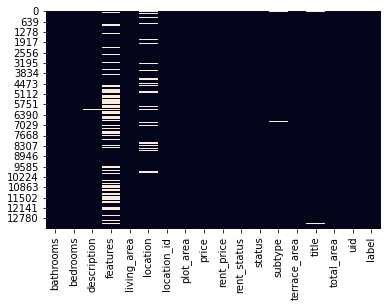

In [11]:
sns.heatmap(df.isnull(), cbar = False)

In [12]:
# Removing features with 30% or more missing values
df = df[[column for column in df if df[column].count() / len(df) >= 0.7]]

In [13]:
# Removing IDs
df = df.drop(["location_id", "uid"], axis = 1)

In [14]:
# Removing observations with missing values
df = df.dropna()

In [15]:
# Checking the duplicate data
df.duplicated().sum()

4083

In [16]:
# Removing duplicates
df = df.drop_duplicates()

In [17]:
df["label"].value_counts()

Apartment    5431
House        2368
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

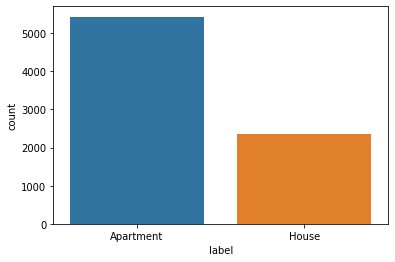

In [18]:
sns.countplot(x = df['label'])

<AxesSubplot:ylabel='label'>

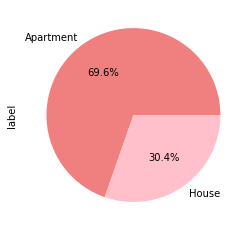

In [19]:
round(df['label'].value_counts()/df.shape[0]*100,2).plot.pie(autopct = '%1.1f%%', colors = ['lightcoral', 'pink'])

In [20]:
# Changing to numeric type
label = LabelEncoder()
df['label'] = label.fit_transform(df['label'])

<AxesSubplot:>

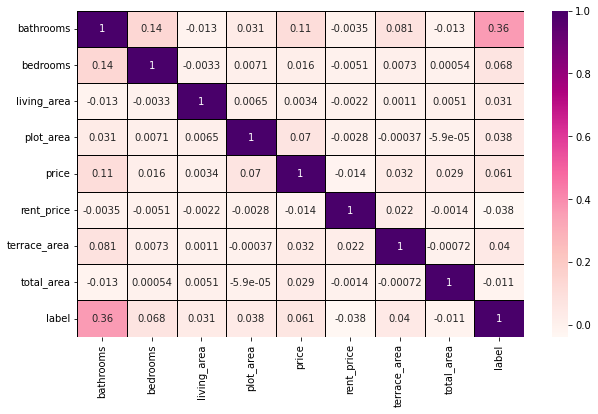

In [21]:
# Checking the correlation
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), cbar = True,annot = True, cmap='RdPu', linewidths=1, linecolor='black')

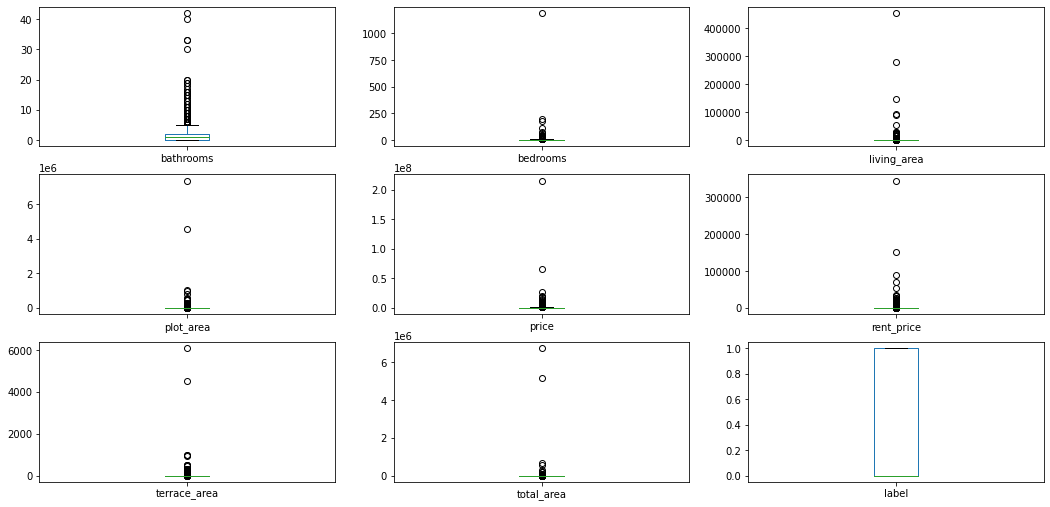

In [22]:
# Checking outliers
df.plot(kind = "box" , subplots = True , figsize = (18,18) ,  layout = (6,3))
plt.show()

In [23]:
# Create training and test sets with the same class distribution
# param data: Dataframe 
# param train_frac: Ratio of train set to whole dataset
# param balanced: Downsample majority class equal to the number of samples in the minority class
create_train_test_sets(df, 0.8, False)

In [24]:
# Load data
df_train, df_dev, df_test = get_data()

---
**Considerations:**

* For preprocessing, we decided to remove features with 30% or more missing values, observations with missing values, duplicated rows, and IDs.
* Our label distribution has a strong imbalance with ~70% representing the majority class (Apartment), and ~30% representing the minority class (House). Our 'create_train_test_sets' function allows us to perform an undersampling if needed.
* The corraltion matrix shows us that our label has a strong relation with the 'bathrooms' feature.
* We can notice that all features have outliers. We plan to address this issue in the future.
---

## 2. Training

In this section, we are going to adopt two pre-trained language models and fine-tune both on the CASAFARI dataset (train and dev splits).

We used the [Transformers library](https://huggingface.co/docs/transformers/index) provided by the Hugging Face with the following pre-trained models:

* **bert-base-uncased**: BERT is a transformers model pretrained on a large corpus in a self-supervised style.
* **distilbert-base-uncased**: DistilBERT is a transformers model, smaller and faster than BERT, which is pretrained also in a self-supervised fashion, using the BERT base model as a teacher.

Our chosen models are pre-trained on Spanish texts.

As an alternative, you can download my trained models [here](https://drive.google.com/drive/folders/1NBi2vfn71PxZ5gNx2DoRkpzSmhGPUOkX?usp=sharing) and save in `./model/`.

In [25]:
from src.models.train_model import TransformerFineTuning

In [26]:
# Pre-treined models
BERT_MODEL = "dccuchile/bert-base-spanish-wwm-uncased"
DISTILBERT_MODEL = "CenIA/distillbert-base-spanish-uncased"

### 2.1 BERT

In [ ]:
# Fine-tune bert model
TransformerFineTuning(BERT_MODEL).train()

### 2.2 DistilBERT

In [ ]:
# Fine-tune the distil bert model
TransformerFineTuning(DISTILBERT_MODEL).train()

## 3. Prediction

In this section, we are going to load the fine-tuned models and predict the probabilities of label 0 (**Apartment**) and label 1 (**House**) for the test cases.

As a baseline, we adopted a Logistic Regression classifier.

In [27]:
from src.models.predict_model import TransformerPredict
from src.models.baseline import BaselinePredict

In [28]:
# Removing label
test = df_test.drop(["label"], axis=1)

In [29]:
# Fine-tuned models
BERT_MODEL = "bert-base-spanish-wwm-uncased-finetuned"
DISTILBERT_MODEL = "distillbert-base-spanish-uncased-finetuned"
BASELINE_MODEL = "LogisticRegression"

In [30]:
COMPARE_BERT_MODEL = True
COMPARE_DISTILBERT_MODEL = True
COMPARE_BASELINE_MODEL = True

In [31]:
# Do I have my bert model available?
if COMPARE_BERT_MODEL and "bert_0" not in df_test:
    
    MODEL_PATH = project_dir / "model" / BERT_MODEL
    
    if not MODEL_PATH.exists():
        raise FileNotFoundError("Failed to load the BERT model")

    model = TransformerPredict(MODEL_PATH)
    
    df_test["bert_0"] = df_test.text.apply(lambda row: model.predict(str(row))[0][0]["score"])
    df_test["bert_1"] = df_test.text.apply(lambda row: model.predict(str(row))[0][1]["score"])

In [32]:
# Do I have my distilbert model available?
if COMPARE_DISTILBERT_MODEL and "distilbert_0" not in df_test:
    
    MODEL_PATH = project_dir / "model" / DISTILBERT_MODEL
    
    if not MODEL_PATH.exists():
        raise FileNotFoundError("Failed to load the distilbert model")

    model = TransformerPredict(MODEL_PATH)
    
    df_test["distilbert_0"] = df_test.text.apply(lambda row: model.predict(str(row))[0][0]["score"])
    df_test["distilbert_1"] = df_test.text.apply(lambda row: model.predict(str(row))[0][1]["score"])

In [ ]:
# Do I have my baseline model available?
if COMPARE_BASELINE_MODEL and "baseline_0" not in df_test:

    model = BaselinePredict(BASELINE_MODEL)
    
    pred = model.predict(test)
    
    df_test["baseline_0"] = [proba[0] for proba in pred]
    df_test["baseline_1"] = [proba[1] for proba in pred]

### 3.1 - Prediction Analysis

In [35]:
import seaborn as sns

In [36]:
# convert the 'model columns' to different rows in my dataframe
# This new data structure facilitates the next analyses
data = []
for i, row in df_test.iterrows():
    for model in ["baseline", "bert", "distilbert"]:
        data.append(
            {
                "text": row["text"],
                "label": row["label"],
                "model": model,
                "score_0": row[model + "_0"],
                "score_1": row[model + "_1"],
            }
        )
df = pd.DataFrame(data)
df.head(10)

,text,label,model,score_0,score_1
0,"InmoCastillejos te consigue tu negocio!. . Ideal para oficina a pie de calle, con posibilidad de multitud de negocios por espacio y buena ubicación.. Local montado para empezar en cuestión de días, diáfano, con un aseo, trastero y galería.. En una calle muy transitada, una inmejorable ubicación para cualquier negocio.. . No lo dudes y ven a visitarlo!",0,baseline,0.835260,0.164740
1,"InmoCastillejos te consigue tu negocio!. . Ideal para oficina a pie de calle, con posibilidad de multitud de negocios por espacio y buena ubicación.. Local montado para empezar en cuestión de días, diáfano, con un aseo, trastero y galería.. En una calle muy transitada, una inmejorable ubicación para cualquier negocio.. . No lo dudes y ven a visitarlo!",0,bert,0.998019,0.001981
2,"InmoCastillejos te consigue tu negocio!. . Ideal para oficina a pie de calle, con posibilidad de multitud de negocios por espacio y buena ubicación.. Local montado para empezar en cuestión de días, diáfano, con un aseo, trastero y galería.. En una calle muy transitada, una inmejorable ubicación para cualquier negocio.. . No lo dudes y ven a visitarlo!",0,distilbert,0.997133,0.002866
3,"Piso de 3 habitaciones en Delicias Vivienda exterior con terraza en el barrio de Delicias, junto a la glorieta de Santa Maria de la Cabeza. Con una superficie de 102 m2 dispone actualmente de 3 dormitorios, baño y aseo, salón comedor con terraza, cocina con office y patio. Se encuentra magníficamente comunicado, a un paso de Madrid Rio y del centro de la ciudad, con una buena oferta de ocio y comercial en la zona, con salida directa a la M-30.",0,baseline,0.860559,0.139441
4,"Piso de 3 habitaciones en Delicias Vivienda exterior con terraza en el barrio de Delicias, junto a la glorieta de Santa Maria de la Cabeza. Con una superficie de 102 m2 dispone actualmente de 3 dormitorios, baño y aseo, salón comedor con terraza, cocina con office y patio. Se encuentra magníficamente comunicado, a un paso de Madrid Rio y del centro de la ciudad, con una buena oferta de ocio y comercial en la zona, con salida directa a la M-30.",0,bert,0.999039,0.000961
5,"Piso de 3 habitaciones en Delicias Vivienda exterior con terraza en el barrio de Delicias, junto a la glorieta de Santa Maria de la Cabeza. Con una superficie de 102 m2 dispone actualmente de 3 dormitorios, baño y aseo, salón comedor con terraza, cocina con office y patio. Se encuentra magníficamente comunicado, a un paso de Madrid Rio y del centro de la ciudad, con una buena oferta de ocio y comercial en la zona, con salida directa a la M-30.",0,distilbert,0.997687,0.002313
6,"Suelo urbano consolidado de uso vivienda plurifamiliar y aparcamiento de superficie 621 m2, ubicado en la calle Turonet número 3, en el municipio de Terrassa, provincia de Barcelona. Terrassa es un municipio grande de la comarca del Valles Occidental, con un total de 210.000 habitantes aproximadamente y que dispone de todos los servicios necesarios, como colegios, restaurantes, hoteles, zonas de ocio. Esta perfectamente comunicada por la C-58.",0,baseline,0.978853,0.021147
7,"Suelo urbano consolidado de uso vivienda plurifamiliar y aparcamiento de superficie 621 m2, ubicado en la calle Turonet número 3, en el municipio de Terrassa, provincia de Barcelona. Terrassa es un municipio grande de la comarca del Valles Occidental, con un total de 210.000 habitantes aproximadamente y que dispone de todos los servicios necesarios, como colegios, restaurantes, hoteles, zonas de ocio. Esta perfectamente comunicada por la C-58.",0,bert,0.998828,0.001172
8,"Suelo urbano consolidado de uso vivienda plurifamiliar y aparcamiento de superficie 621 m2, ubicado en la calle Turonet número 3, en el municipio de Terrassa, provincia de Barcelona. Terrassa es un municipio grande de la comarca del Valles Occidental, con un total de 210.000 habitantes aproximadamente y que dispone de todos los servicios necesarios, como colegios, restaurantes, hoteles, zonas de ocio. 

**Which density distribution do we have on the predicted scores?**

Density distribution of label 0 (Apartment)

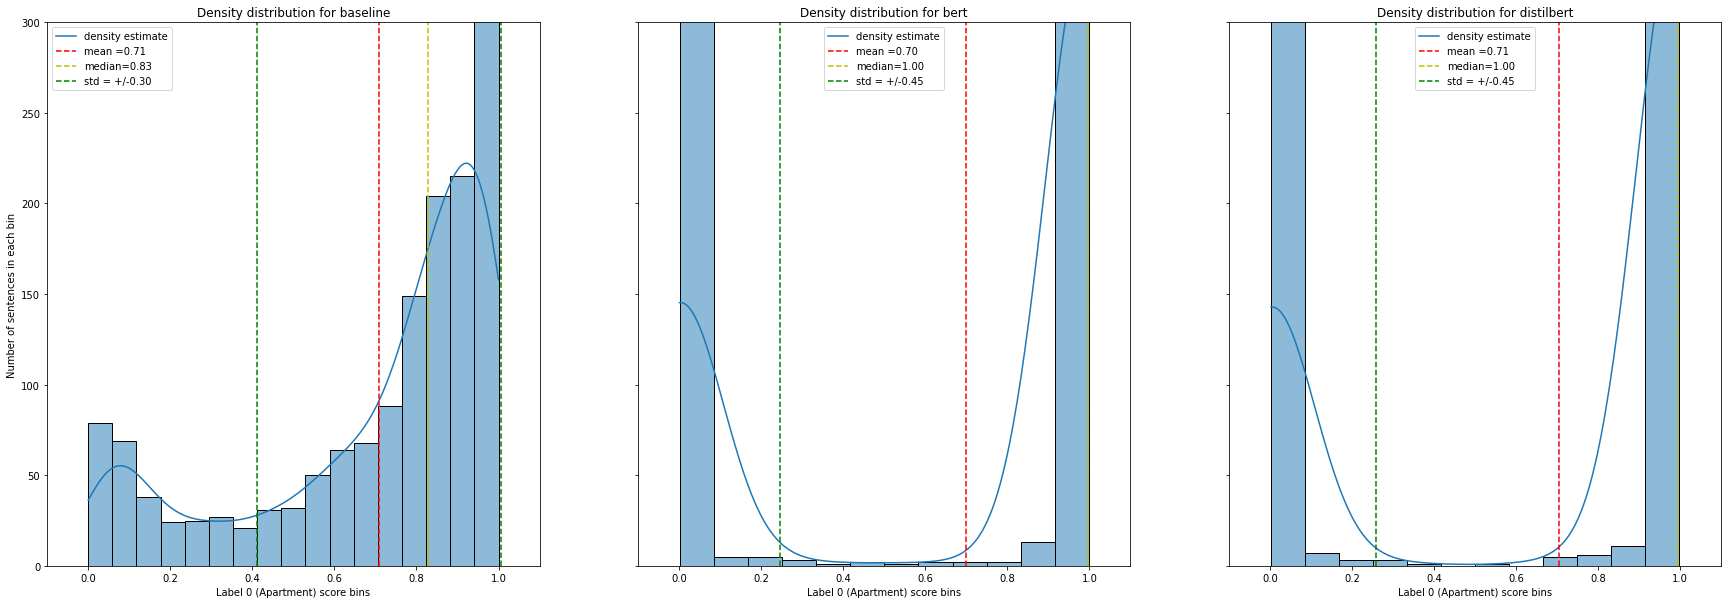

In [37]:
# Plot the density distribution of label 0 (Not-hate)
fig, axes = plt.subplots(ncols=len(df.model.unique()), nrows=1, figsize=(30, 10))

# plot each one of the density functions
for i, model in enumerate(df.model.unique()):
    ax = axes[i]
    sns.histplot(x="score_0", data=df[df.model == model], ax=ax, kde=True)
    mean = df[df.model == model].score_0.mean()
    std = df[df.model == model].score_0.std()
    median = df[df.model == model].score_0.median()

    ax.set_xlabel("Label 0 (Apartment) score bins")
    ax.set_ylabel("Number of sentences in each bin")
    ax.axvline(mean, color="r", linestyle="--")
    ax.axvline(median, color="y", linestyle="--")
    ax.axvline(mean + std, color="g", linestyle="--")
    ax.axvline(mean - std, color="g", linestyle="--")
    ax.legend(
        [
            "density estimate",
            f"mean ={mean:.2f}",
            f"median={median:.2f}",
            f"std = +/-{std:.2f}",
        ]
    )
    
    # put every plot in the same scale
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0, 300])
    ax.label_outer()

    ax.set_title(f"Density distribution for {model}")

Density distribution of label 1 (House)

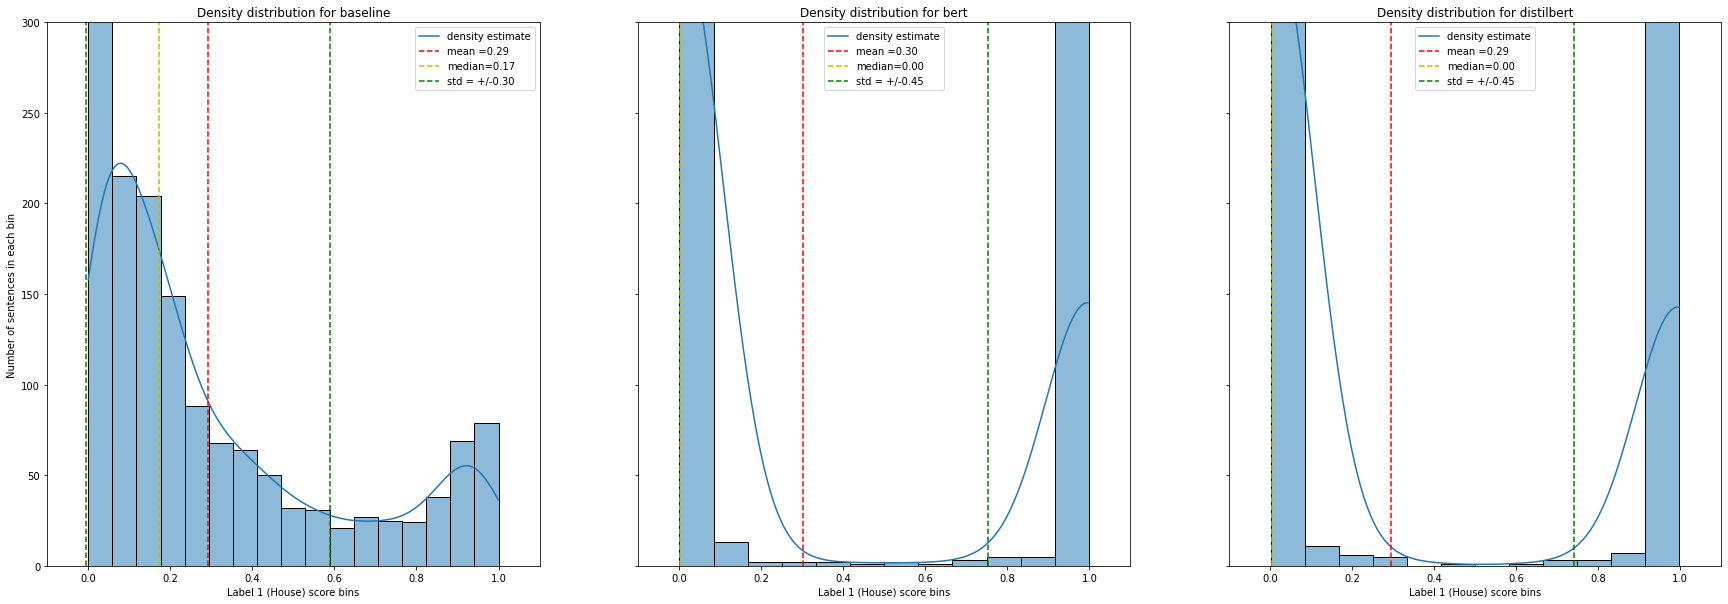

In [38]:
# Plot the density distribution of score 1
fig, axes = plt.subplots(ncols=len(df.model.unique()), nrows=1, figsize=(30, 10))

# plot each one of the density functions
for i, model in enumerate(df.model.unique()):
    ax = axes[i]
    sns.histplot(x="score_1", data=df[df.model == model], ax=ax, kde=True)
    mean = df[df.model == model].score_1.mean()
    std = df[df.model == model].score_1.std()
    median = df[df.model == model].score_1.median()

    ax.set_xlabel("Label 1 (House) score bins")
    ax.set_ylabel("Number of sentences in each bin")
    ax.axvline(mean, color="r", linestyle="--")
    ax.axvline(median, color="y", linestyle="--")
    ax.axvline(mean + std, color="g", linestyle="--")
    ax.axvline(mean - std, color="g", linestyle="--")
    ax.legend(
        [
            "density estimate",
            f"mean ={mean:.2f}",
            f"median={median:.2f}",
            f"std = +/-{std:.2f}",
        ]
    )
    
    # put every plot in the same scale
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0, 300])
    ax.label_outer()

    ax.set_title(f"Density distribution for {model}")

Visualization on the data points, their class and the best threshold obtained

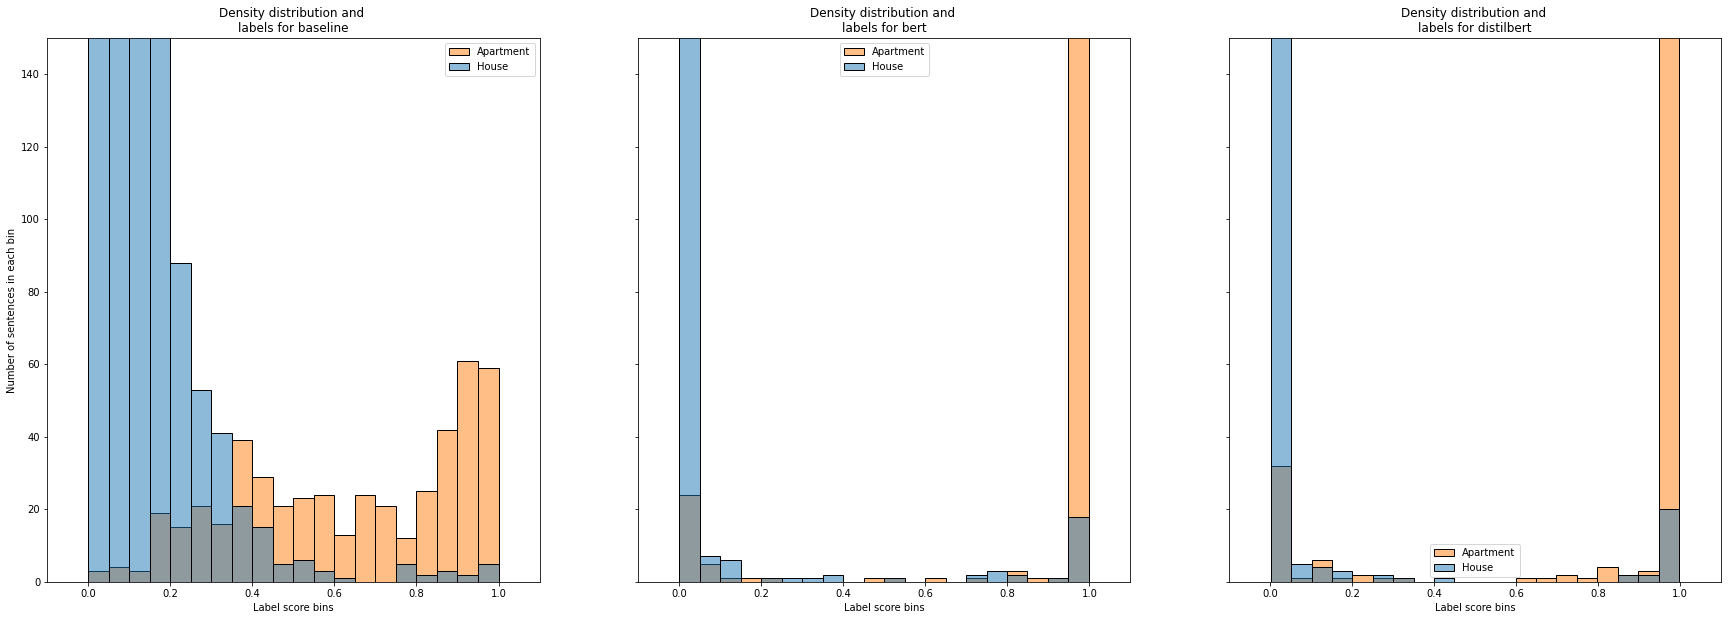

In [39]:
# This chart provides a visualization on the data points, their class and the best threshold obtained.
fig, axes = plt.subplots(ncols=len(df.model.unique()), nrows=1, figsize=(30, 10))

# plot each model
for i, model in enumerate(df.model.unique()):

    ax = axes[i]

    sns.histplot(df[df.model == model], x="score_1", hue="label", bins=20, ax=ax)

    ax.set(
        xlabel="Label score bins",
        title=f"Density distribution and \nlabels for {model}",
    )
    ax.set_ylabel("Number of sentences in each bin"),
    ax.legend(
        [
            "Apartment",
            "House",
        ]
    )

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0, 150])
    ax.label_outer()

---
**Considerations:**

* Our models density distribution ('bert' and 'distilbert') behaves like an U-Shaped distribution.
* The 'baseline' model density distribution behaves like a positive skewed distribution.
* Our models density distribution ('bert' and 'distilbert') have two peaks, one close to zero and the other close to 1. These peaks highlight the contrastive learning applied in the fine-tuning stage.
* The 'baseline' model distribution has a threshold closer to 0.35, being 'optimistic' about the label 0 (Apartment).
---

## 4. Evaluation

In this section, we are going to use different evaluations metrics to report the performance of each model in the test set. The following metrics will be used: 

* **ROC curve**
* **Precision vs recall curve**
* **Classification metrics** (precision, recall, f-score).

In [40]:
import numpy as np
from sklearn.metrics import roc_curve, auc

### 4.1. ROC Curve

To compare different models, we plot the ROC curve and measure the area under the curve (AUC).

An [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

* True Positive Rate
* False Positive Rate

True Positive Rate (TPR) is a synonym for recall and is therefore defined as follows:

* TPR = TP / TP + FN

False Positive Rate (FPR) is defined as follows:

* FPR = FP / FP + TN

With the ROC curve, we can measure the **area under the curve (AUC)**. AUC represents the probability that a random positive example (1 - House) is positioned to the right of a random negative (0 - Apartment) example. AUC ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.

This section shows the AUC - ROC curve calculations for our models.

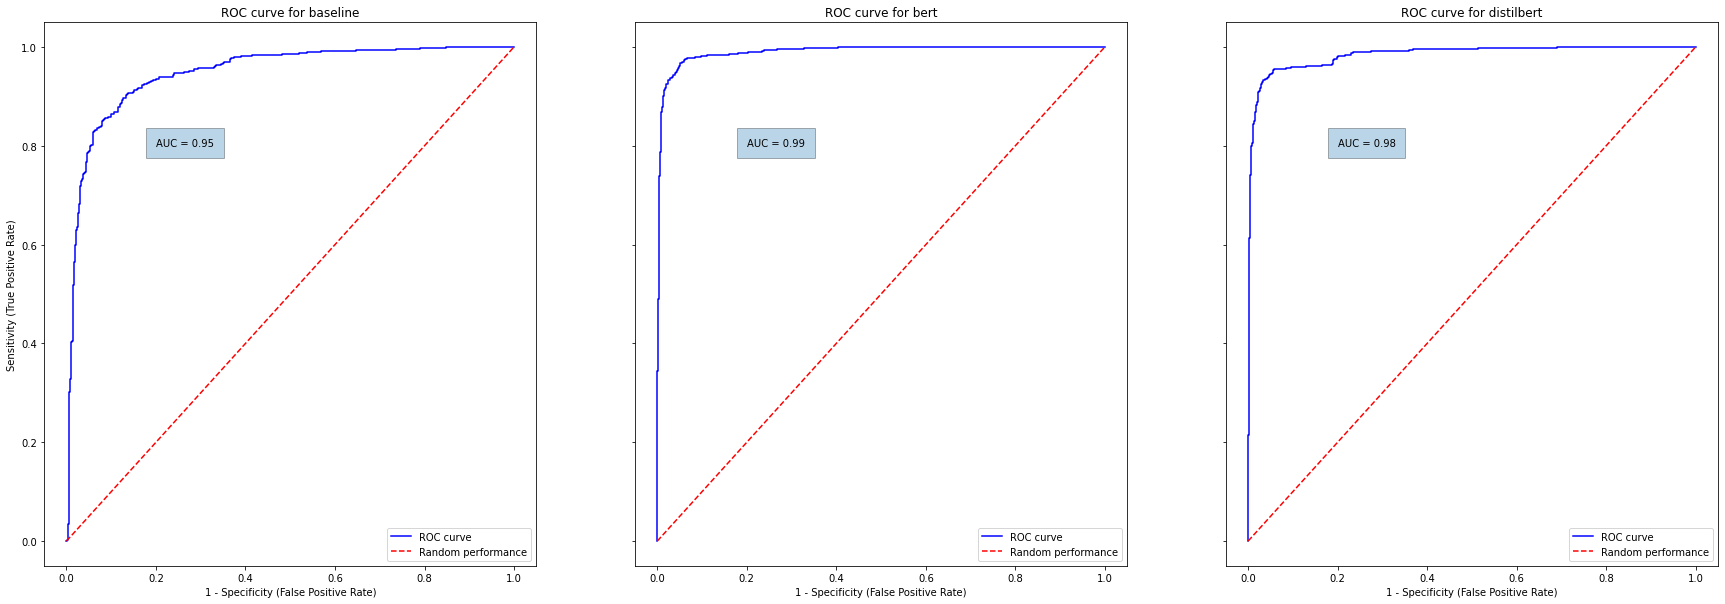

In [41]:
fig, axes = plt.subplots(ncols=len(df.model.unique()), nrows=1, figsize=(30, 10))

# plot the ROC curve for each model being evaluated
for i, model in enumerate(df.model.unique()):
    scores = df[df.model == model]["score_1"]
    y = np.array(df[df.model == model]["label"])

    fpr, tpr, thresholds = roc_curve(y, scores, pos_label=1)
    auc_score = auc(fpr, tpr)

    ax = axes[i]
    ax.plot(fpr, tpr, "b", label=f"ROC curve", axes=axes[i])
    ax.set_title(f"ROC curve for {model}")
    ax.text(0.2, 0.8, f'AUC = {auc_score:.2f}', bbox={'alpha': 0.3, 'pad': 10})
    ax.plot([0, 1], [0, 1], "r--", label="Random performance")
    ax.legend(loc="lower right")
    ax.set_ylabel("Sensitivity (True Positive Rate)")
    ax.set_xlabel("1 - Specificity (False Positive Rate)")
    ax.label_outer()

---
**Considerations:**

* By inspecting the behaviour for the ROC curve, we can see that the area under the curve (AUC) for our models 'bert' (0.99) and 'distilbert' (0.98) are higher when compared with the 'baseline' (0.95). This demonstrate that our models have better performance on predicting if an example is a House or not.
* The performance of the 'distilbert' model is very close to the performance of the 'bert' model, indicating that both fit well the problem.
* ROC curves for 'bert' and 'distilbert' models are close to 1 (best score) which shows that, even with the complexity of the problem, our models are able to predict the correct labels.
---

### 4.2. Precision vs Recall curve

The [Precision vs Recall curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) compute precision-recall pairs for different probability thresholds. It is usual to compare the models when we have a strong imbalance problems.

Similar to the ROC curve, we can also measure the [**Average Precision (AP)**](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html) that summarizes such a plot as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight. The results close to 1 are better.

In [42]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score

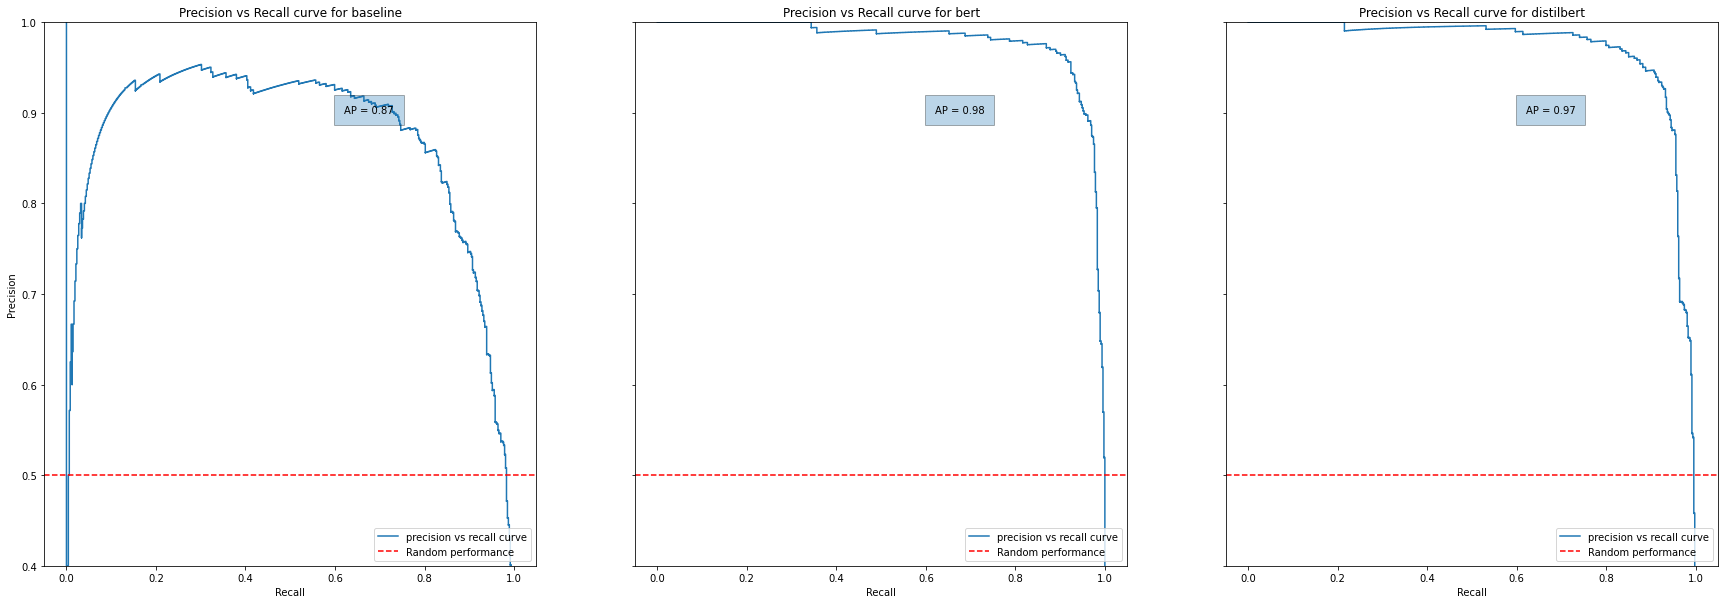

In [43]:
fig, axes = plt.subplots(ncols=len(df.model.unique()), nrows=1, figsize=(30, 10))

# plot the precision vs recall curve for each model being evaluated
for i, model in enumerate(df.model.unique()):
    scores = df[df.model == model]["score_1"]
    y = np.array(df[df.model == model]["label"])
    precision, recall, thresholds = precision_recall_curve(y, scores, pos_label=1)

    # measure the average precision score
    ap_score = average_precision_score(y, scores)
    
    ax = axes[i]
    PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=ax, label=f"precision vs recall curve")

    ax.set_title(f"Precision vs Recall curve for {model}")
    ax.axhline(0.5, ls="--", color="r", label="Random performance")
    ax.text(0.62, 0.9, f'AP = {ap_score:.2f}', bbox={'alpha': 0.3, 'pad': 10})
    ax.legend(loc="lower right")
    
    ax.set_ylim([0.4, 1])
    ax.label_outer()

---
**Considerations:**
* The Precision vs Recall curves shows the good performance of 'bert' and 'distilbert' models in predicting the right labels.
* The best performance was for the 'bert' model with 0.98 of Average Precision.
---

### 4.3. Binary Classification

In this section, we want to measure the performance of a classification setup. In this way, we want to predict the label in the test set by using the probability score provided by each model.

#### 4.3.1. Prediction

In [44]:
def binary_classifier(value, threshold):
    if value > threshold:
        return 1
    else:
        return 0


# compute the precision of each example using a mocked threshold
df["prediction"] = df.apply(
    lambda row: binary_classifier(float(row["score_1"]), 0.5), axis=1
)

In [45]:
df.head()

,text,label,model,score_0,score_1,prediction
0,"InmoCastillejos te consigue tu negocio!. . Ideal para oficina a pie de calle, con posibilidad de multitud de negocios por espacio y buena ubicación.. Local montado para empezar en cuestión de días, diáfano, con un aseo, trastero y galería.. En una calle muy transitada, una inmejorable ubicación para cualquier negocio.. . No lo dudes y ven a visitarlo!",0,baseline,0.835260,0.164740,0
1,"InmoCastillejos te consigue tu negocio!. . Ideal para oficina a pie de calle, con posibilidad de multitud de negocios por espacio y buena ubicación.. Local montado para empezar en cuestión de días, diáfano, con un aseo, trastero y galería.. En una calle muy transitada, una inmejorable ubicación para cualquier negocio.. . No lo dudes y ven a visitarlo!",0,bert,0.998019,0.001981,0
2,"InmoCastillejos te consigue tu negocio!. . Ideal para oficina a pie de calle, con posibilidad de multitud de negocios por espacio y buena ubicación.. Local montado para empezar en cuestión de días, diáfano, con un aseo, trastero y galería.. En una calle muy transitada, una inmejorable ubicación para cualquier negocio.. . No lo dudes y ven a visitarlo!",0,distilbert,0.997133,0.002866,0
3,"Piso de 3 habitaciones en Delicias Vivienda exterior con terraza en el barrio de Delicias, junto a la glorieta de Santa Maria de la Cabeza. Con una superficie de 102 m2 dispone actualmente de 3 dormitorios, baño y aseo, salón comedor con terraza, cocina con office y patio. Se encuentra magníficamente comunicado, a un paso de Madrid Rio y del centro de la ciudad, con una buena oferta de ocio y comercial en la zona, con salida directa a la M-30.",0,baseline,0.860559,0.139441,0
4,"Piso de 3 habitaciones en Delicias Vivienda exterior con terraza en el barrio de Delicias, junto a la glorieta de Santa Maria de la Cabeza. Con una superficie de 102 m2 dispone actualmente de 3 dormitorios, baño y aseo, salón comedor con terraza, cocina con office y patio. Se encuentra magníficamente comunicado, a un paso de Madrid Rio y del centro de la ciudad, con una buena oferta de ocio y comercial en la zona, con salida directa a la M-30.",0,bert,0.999039,0.000961,0


#### 4.3.2. Classification Report

For each one of the classification classes, we can mesure the following classification metrics:

* **precision** - TP / (TP + FP) - the number of correcly classified in this class divided by the total number of elements labelled as belonging to the given class [[ref](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context))];
* **recall** - TP / (TP + FN) - the number of correcly classified in this class divided by the total number of elements that actually belong to this class [[ref](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context))];
* **f1** - 2*(precion+recall)/(precision+recall) - weighted average of the precision and recall.

In addition, for each classifier, disregarding the class, we can measure the overall accuracy:

* **accuracy** - the number of correctly classified over the number of all sentences, i.e, (TP+TN) / (TP+TN+FP+FN)

In [46]:
from sklearn.metrics import classification_report
from src.data.text_preprocessing import convert_labels

In [47]:
# plot for each model
for i, model in enumerate(df.model.unique()):
    y_true = df[df.model == model]["label"]
    y_pred = df[df.model == model]["prediction"]
    print(model)
    print(classification_report(y_true, y_pred, target_names=["Apartment", "House"]))

baseline
              precision    recall  f1-score   support

   Apartment       0.86      0.98      0.91      1086
       House       0.92      0.64      0.76       474

    accuracy                           0.87      1560
   macro avg       0.89      0.81      0.84      1560
weighted avg       0.88      0.87      0.87      1560

bert
              precision    recall  f1-score   support

   Apartment       0.97      0.98      0.97      1086
       House       0.94      0.93      0.94       474

    accuracy                           0.96      1560
   macro avg       0.96      0.95      0.95      1560
weighted avg       0.96      0.96      0.96      1560

distilbert
              precision    recall  f1-score   support

   Apartment       0.96      0.98      0.97      1086
       House       0.95      0.91      0.93       474

    accuracy                           0.96      1560
   macro avg       0.95      0.94      0.95      1560
weighted avg       0.96      0.96      0.96      

#### 4.3.3. Confusion Matrix

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

The confusion matrix shows us how the classification occurred in each class and how many are:

* True Positives (model predicted 1 = House -> right class)
* True Negatives (model predicted 0 = Apartment -> right class)
* False Positives (model predicted 1 = House -> wrong class)
* False Negatives (model predicted 0 = Apartment -> wrong class).

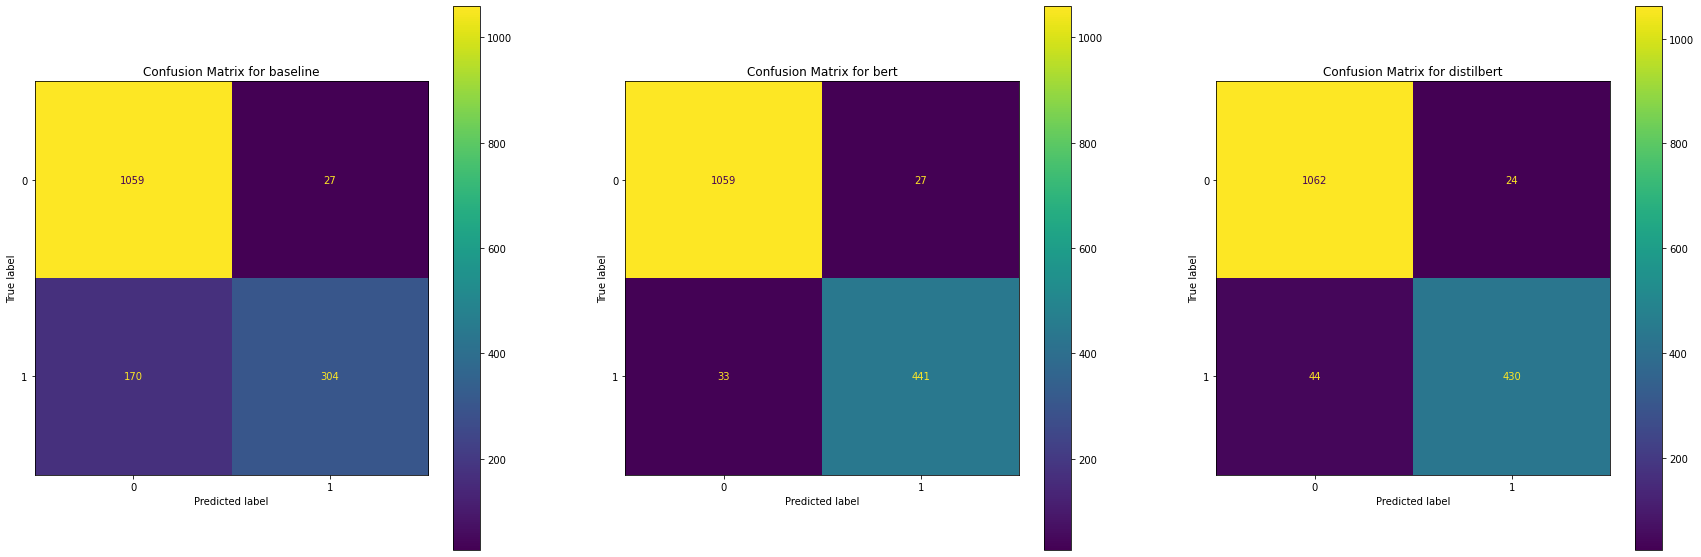

In [49]:
fig, axes = plt.subplots(ncols=len(df.model.unique()), nrows=1, figsize=(30, 10))

# plot for each model
for i, model in enumerate(df.model.unique()):
    ax = axes[i]
    cm = confusion_matrix(df[df.model == model]["label"], df[df.model == model]["prediction"])
    cm_display = ConfusionMatrixDisplay(cm).plot(ax=ax)
    ax.set_title(f"Confusion Matrix for {model}")

---
**Considerations:**
* We observed a better capability in our 'bert' model to balance between precision (0.94) and recall (0.93) which lead to a good f1-score (0.94) for the 'House' class.
* The 'bert' model has a higher f1-score (0.94) when compared with the 'baseline' model (0.76) for the 'House' class.
* As the 'baseline' model is optimistic regarding the 'Apartment' class (threshold 0.35), it classifies more Houses as Apartments than the opposite (high precision vs low recall for the 'House' class).
* We observe the 'baseline' tendency to everestimate the Apartment prediction. As it includes most of the examples as 'Apartment', it fails more on predicting the 'House' class (low recall - 0.64 and high error rate for 'Apartment' predictions - #170)
---